<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#README:-How-to-use-this-notebook" data-toc-modified-id="README:-How-to-use-this-notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>README: How to use this notebook</a></span></li><li><span><a href="#Imports-and-setup" data-toc-modified-id="Imports-and-setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports and setup</a></span></li><li><span><a href="#Image-Regions" data-toc-modified-id="Image-Regions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Image Regions</a></span></li><li><span><a href="#Train,-val,-test-split" data-toc-modified-id="Train,-val,-test-split-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train, val, test split</a></span></li><li><span><a href="#Inputs-and-ends" data-toc-modified-id="Inputs-and-ends-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Inputs and ends</a></span></li><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>DataLoader</a></span></li><li><span><a href="#Test-run" data-toc-modified-id="Test-run-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Test run</a></span><ul class="toc-item"><li><span><a href="#Slice-.nc-file-images-into-desired-regions-and-save-to-.npy-files" data-toc-modified-id="Slice-.nc-file-images-into-desired-regions-and-save-to-.npy-files-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Slice .nc file images into desired regions and save to .npy files</a></span></li><li><span><a href="#Get-train,-val,-test-split" data-toc-modified-id="Get-train,-val,-test-split-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Get train, val, test split</a></span></li><li><span><a href="#Create-DataLoader-for-training-data" data-toc-modified-id="Create-DataLoader-for-training-data-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Create DataLoader for training data</a></span></li></ul></li></ul></div>

# README: How to use this notebook

First, install the libraries needed below. This can be done with either of the following shell commands:

`pip install package-name` or `conda install package-name`

This notebook assumes only that you have a directory with netCDF (.nc) files with SST data to load and an empty directory for numpy (.npy) files, which will be populated in the process of running the notebook. Be sure to update the paths to both of these directories in [Section 2](#2-Imports-and-setup) below. For help installing the data used in this project, see the DataProc notebook (WIP).

Then run each of the cells in Sections [2](#2-Imports-and-setup) through [6](#6-DataLoader) - these will provide all the methods you need to create a DataLoader for the netCDF files. Finally, run the cells in [Section 7](#7-Test-run) to test that everything worked correctly. 

This file was last updated on August 2nd, 2023. 

# Imports and setup

In [25]:
import datetime
import math
import os
import torch

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

In [20]:
# Update these with the correct paths for your device
# Don't forget the '/' at the end!

# Path to directory holding netCDF (.nc) files
NC_FILES_DIR = ""

# Path to directory for numpy (.npy) files
NPY_FILES_DIR = ""

# Image Regions

In [3]:
def slice_img(img, end_shape):
    """Method to slice large satellite images into MxN regions, where the 
       given dimensions M and N are smaller than the original image dimensions.
       
       Parameters
       ----------
       img : numpy.ndarray : the image to slice
       end_shape : tuple : the desired end shape for the sliced regions
       
       Returns
       -------
       slice_dataset : dictionary : contains the region slices (np.ndarray's),
       identified by a string "region_XX"
    """
    
    slice_dataset = {}
    M, N = end_shape[0], end_shape[1]
    m, n = img.shape[0], img.shape[1]
    
    # TODO: update to call TorchVision for Nils' data
    assert (m > M) & (n > N), "Image too small for desired slice."
    
    n_regions = math.floor(m / M) * math.floor(n / N)
    delta = M
    
    starti = 0
    endi = M
    startj = 0
    endj = N
    
    region = 0
    
    #print("Slicing image into " + str(n_regions) + " regions...")
    
    for i in range(math.floor(m / M)):
        for j in range(math.floor(n / N)):
            
            #print("Region: " + str(region))
            slice_key = "region_" + str(region)
            
            #print("(" + str(starti) + ", " + str(endi) + ")")
            #print("(" + str(startj) + ", " + str(endj) + ")")
            
            slice_dataset[slice_key] = img[starti:endi, startj:endj]
            
            startj = endj
            endj += delta
            
            region += 1
        
        starti = endi
        endi += delta
        
        startj = 0
        endj = delta
            
    return slice_dataset

# Train, val, test split

In [4]:
def all_days(files):
    """Helper method to take a list of filenames and return the total number 
    of days represented by the files in the list. 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    files : list : data file names
    
    Returns
    -------
    delta : int : the number of days represented by the inputted files
    """
    
    files.sort()
    
    first = datetime.datetime.strptime(files[0][8:16], "%Y%m%d").date()
    last = datetime.datetime.strptime(files[len(files)-1][8:16], "%Y%m%d").date()
    
    delta = int((last - first) / datetime.timedelta(days=1))
    
    return delta

def train_val_test_cutoffs(topdir, split):
    """Helper method to create lists of filenames for the train, val, and test
    data splits. Uses the dates in the filenames to determine file order and 
    split cutoffs. 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
       
    Parameters
    ----------
    topdir : string : the path to the directory holding the data
    ndays : int : the total number of days in the dataset
    split : list : the fractions for each split, eg. [0.8, 0.1, 0.1]
    
    Returns
    -------
    cutoffs : list : date cutoffs for each split
    """
    
    all_files = os.listdir(topdir)
    all_files.sort()
    nfiles = len(all_files)
    ndays = all_days(all_files)
    
    start_date = datetime.datetime.strptime(all_files[0][8:16], "%Y%m%d").date()
    end_date = datetime.datetime.strptime(all_files[nfiles-1][8:16], "%Y%m%d").date()
    
    cutoffs = []
    
    for i in range(3):
        delta = math.floor(ndays*split[i])
        end = start_date + datetime.timedelta(days=delta)
        cutoffs.append(end)
        
        start_date = end
        
    # Because of rounding, some files may have been missed
    # Add these to the test split
    if cutoffs[2] < end_date:
        cutoffs[2] = end_date
    
    return cutoffs

def train_val_test_split_files(topdir, split):
    """Method to split the data in a directory into training, validation, and
    test sets. Uses the helper method train_val_test_cutoffs(). 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    topdir : string : the path to the directory holding the data
    split : list : the fractions for each split, eg. [0.8, 0.1, 0.1]
    
    Returns
    -------
    train : list : list of filenames for the train set
    val : list : list of filenames for the validation set
    test : list : list of filenames for the test set
    """
    
    assert len(split) == 3, "Please include a % split for train, validation, and test sets."
    
    cutoffs = train_val_test_cutoffs(topdir, split)
    
    all_files = os.listdir(topdir)
    all_files.sort()
    
    train, val, test = [], [], []
    
    for f in all_files:
        file_date = datetime.datetime.strptime(f[8:16], "%Y%m%d").date()
        
        if file_date <= cutoffs[0]:
            train.append(f)
        elif (file_date > cutoffs[0]) & (file_date <= cutoffs[1]):
            val.append(f)
        else:
            test.append(f)
            
    return train, val, test

In [5]:
def load_data_from_file(filename):
    """Helper method to load a single .npy file."""
    
    return np.load(NPY_FILES_DIR + filename)

def load_data_from_files(files):
    """Method to load data from a list of .npy files."""
    data = []
    for f in files:
        data.append(load_data_from_file(f))
        
    return np.array(data)

# Inputs and ends

In [6]:
def all_regions(files):
    """Helper method to take a list of filenames and return a list of the 
    unique region numbers. 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    files : list : data file names
    
    Returns
    -------
    regions : list : list of unique region numbers in the directory
    """
    
    files.sort()
    regions = []
    
    for f in files:
        if "region_" in f:
            
            start_ind = f.find("region_") + len("region_")
            end_ind = f.find(".npy")
            
            reg = f[start_ind:end_ind]
            
            if int(reg) not in regions:
                regions.append(int(reg))
            
        else:
            print("Files in this directory do not match the naming convention.")
    
    regions.sort()
    
    return regions

def search_by_region(files, region):
    """Helper method to search a list of files for only those corresponding to
    a desired region. 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    files : list : list of filenames in which to search
    region : int : desired region
    
    Returns
    -------
    region_files : list : sorted list of matching files
    """
    
    region_files = []
    for fname in files:
        if "region_" + str(region) + ".npy" in fname:
            region_files.append(fname)
            
    region_files.sort()
    
    return region_files

def get_pairs_by_region(files, region, ndays=1):
    """Method to separate data into inputs (X) and ends (y), for example to
    use 4 previous days (ndays=4) to predict the next day. The "pairs" are 
    pairs of (X,y) inputs and ends. This method works on one region at a time.
    
    Parameters
    ----------
    files : list : list of files from which to get pairs
    region : int : desired region
    ndays : int : number of days to use as inputs
    
    Returns
    -------
    inps : np.ndarray : filenames for inputs
    ends : list : filenames for ends
    """
    
    region_files = search_by_region(files, region)
    
    n = len(region_files)
    
    inps = []
    ends = region_files[ndays:]
    
    for i in range(n - ndays):
        inps.append(region_files[i:i+ndays])
    
    return np.array(inps), np.array(ends)

# DataLoader

In [7]:
def create_training_dataloader(dtype, batchsize, files, ndays):
    """Method to create a PyTorch DataLoader object from a list of files and
    additional parameters.
    
    Parameters
    ----------
    dtype : torch.dtype : the data type for the DataLoader
    batchsize : int : the desired batchsize for loading data
    files : str : a list of files holding data to put into the DataLoader
    ndays : int : the number of days to use as inputs to predict the next day
    
    Returns
    -------
    training : torch.utils.data.DataLoader : the DataLoader object
    """
    
    regions = all_regions(files)

    train_data = []
    train_ends = []

    for reg in regions:
        train_reg_pairs = get_pairs_by_region(files, reg, ndays)
        
        for i in range(len(train_reg_pairs[0])):
            dat = load_data_from_files(train_reg_pairs[0][i])
            end = load_data_from_file(train_reg_pairs[1][i])
        
            train_data.append(dat)
            train_ends.append(end)
        
    train_data = torch.from_numpy(np.array(train_data)).type(dtype)
    train_ends = torch.from_numpy(np.array(train_ends)).type(dtype)
    
    training = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_ends),
                                           batch_size=batchsize, shuffle=False)
    
    return training

# Test run

In [19]:
if NC_FILES_DIR == "" or NPY_FILES_DIR == "":
    print("Don't forget to update the paths!")
    
if NC_FILES_DIR[-1] != '/':
    NC_FILES_DIR += "/"
    print(NC_FILES_DIR)
    
if NPY_FILES_DIR[-1] != '/':
    NPY_FILES_DIR += "/"
    print(NPY_FILES_DIR)

/home/lucia/projects/FORMES/rainfall-pde-ml/data/cdo_out/


## Slice .nc file images into desired regions and save to .npy files

In [21]:
# Note: creates > 35,000 .npy files, ~590 MB 
# Compared to 749 .nc files, ~410 MB

for f in os.listdir(NC_FILES_DIR):
    ncd = nc.Dataset(NC_FILES_DIR + f)
    
    # First, flip the image from (lon, lat) to (lat, lon)
    # Then take the array with the variable of interest: SST (thetao)
    # Optionally, slice into a "nice" image: 768x256 is easily divisible by 64x64
    arr = np.flip(ncd["thetao"][:][0, 0, :768, :256].data) 
    
    regions = slice_img(arr, (64,64))  # Now slice the images
    
    for reg, img in regions.items():
        
        # Important: do not change this file naming convention without 
        # updating the methods above
        filename = f + "_" + str(reg) + ".npy" 
        np.save(NPY_FILES_DIR + filename, img)
        
print("Done.")

Done.


## Get train, val, test split

In [22]:
split = train_val_test_split_files(NPY_FILES_DIR, [0.8, 0.1, 0.1])

train_split = split[0]
val_split   = split[1]
test_split  = split[2]

print(len(train_split))
print(len(val_split))
print(len(test_split))

28752
3552
3648


## Create DataLoader for training data

In [23]:
test_loader = create_training_dataloader(dtype=torch.FloatTensor, 
                                         batchsize=16, files=train_split, 
                                         ndays=4)

torch.Size([16, 4, 64, 64])
torch.Size([16, 64, 64])


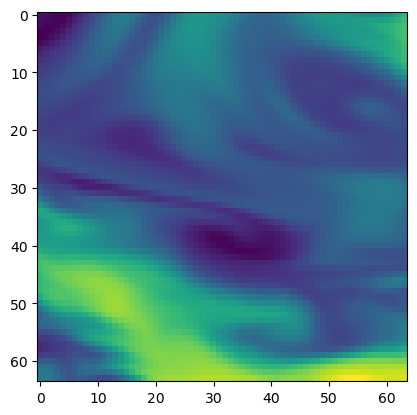

In [26]:
# Display a test image

train_first, train_next = next(iter(test_loader)) 

print(train_first.shape)
print(train_next.shape)

plt.imshow(train_first[0][0]) # The first input image in the first batch
plt.show()